In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
import nltk
import string
import re
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from sklearn import datasets
data1=datasets.load_files(r"C:\Users\Satyam Garg\Desktop\python\Projects\Project-Text Classifiaction\Submission\20_newsgroups")
x=data1.data
Y_train=data1.target

In [3]:
print(type(x))

<class 'list'>


In [4]:
nltk.download("stopwords")
stop_words=(stopwords.words("english"))
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to C:\Users\Satyam
[nltk_data]     Garg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
## Data Cleaning
X=[]

for i in range(len(x)):
    # to remove all the special character
    document = re.sub(r'\W', ' ', str(x[i]))
    
    # to convert multiple spaces into single spaces
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # removed prefixed b
    document = re.sub(r'^b\s+', '', document)
    
    # remove integers
    document = re.sub(r'\d+', '', document)
    
    # convert all words into lowerletter
    document = document.lower()
    
    X.append(document)

len(X)

19997

In [6]:
dictionary = {}
for i in X:
    for j in i.split():
        if j not in stop_words :
            dictionary[j] = dictionary.get(j,0)+1
    
len(dictionary)

164593

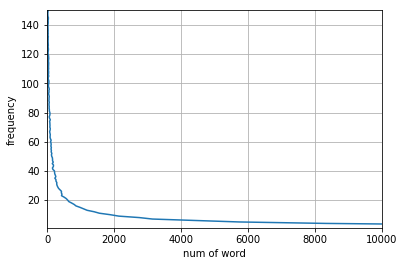

In [7]:
maxf = max(dictionary.values())+1
freqCounts = [0 for i in range(maxf)]
x_array = [i for i in range(maxf)]
for i in dictionary:
    freqCounts[dictionary[i]] += 1
plt.plot(freqCounts,x_array)
plt.xlabel("num of word")
plt.ylabel("frequency")
plt.axis([0,10000,1,150])
plt.grid()
plt.show()

In [8]:
CutoffPoint = 120
vocab = {}
for key in dictionary:
    if(dictionary[key] >= CutoffPoint):
        vocab[key] = dictionary[key]
indexes = list(vocab.keys())

print(len(vocab))


5078


In [9]:
#Converting to a 2D numpy array
DataPoints = len(X)
num_features = len(vocab)
train_data = np.zeros((DataPoints, num_features))
i = 0
for doc in X:
    for word in doc.split():
        if word in vocab.keys():
            train_data[i][indexes.index(word)] += 1
    i += 1
train_data

array([[1., 1., 2., ..., 0., 0., 0.],
       [0., 2., 3., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [39]:
def fit(X_train , Y_train):
    trained_matrix = {}
    trained_matrix["total_data_len"] = len(X_train)
    
    all_classes = set(Y_train)
    for c_class in all_classes:
        trained_matrix[c_class] = {}
        y_temp = Y_train[Y_train == c_class]
        x_temp = X_train[Y_train == c_class]
        trained_matrix[c_class]["total_rows_in_class"] = len(y_temp)
        trained_matrix[c_class]["total_words_in_class"] = 0
        for j in range(num_features):
            trained_matrix[c_class][j] = np.sum(x_temp[:, j])
            trained_matrix[c_class]["total_words_in_class"] += np.sum(x_temp[:, j])
        
    return trained_matrix
    
def get_prob_for_class(x_input, trained_data, c_class):
    ans = np.log(trained_data[c_class]["total_rows_in_class"]) - np.log(trained_data["total_data_len"])
    for j in range(len(x_input)):
        numerator = trained_data[c_class][j]+1   # +1 for laplace correction
        denominator = trained_data[c_class]["total_words_in_class"]+len(x_input)
        ans += x_input[j]*(np.log(numerator) - np.log(denominator))
    return ans
            
            
    
def predictSingleInput(trained_data, x_input):
    
    best_class = 0
    best_p = -10
    first = True
    for c_class in trained_data.keys():
        if(c_class == "total_data_len"):
            continue
        p = get_prob_for_class(x_input, trained_data, c_class)
        if(first or p>best_p):
            best_p = p
            best_class = c_class
            first = False
    return best_class
        
def predict(x_data,trained_data):
    y_predict = []
    for test in x_data:
        y_predict.append(predictSingleInput(trained_data, test))
    
    return y_predict

def score(y_1, y_2):
    ans = 0
    for i in range(len(y_1)):
        if(y_1[i] == y_2[i]):
            ans += 1
    return ans/len(y_1)

In [13]:
final_matrix = fit(train_data,Y_train)

In [16]:
final_matrix.keys()

dict_keys(['total_data_len', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [20]:
test_data=datasets.load_files(r"C:\Users\Satyam Garg\Desktop\python\Projects\Project-Text Classifiaction\Submission\mini_newsgroups")
x_test=test_data.data
Y_test=test_data.target

In [26]:

def get_data(x_test_sentences,vocab,indexes):
    X_test=[]
    for i in range(len(x_test)):
        # to remove all the special character
        document = re.sub(r'\W', ' ', str(x_test[i]))

        # to convert multiple spaces into single spaces
        document = re.sub(r'\s+', ' ', document, flags=re.I)

        # removed prefixed b
        document = re.sub(r'^b\s+', '', document)

        # remove integers
        document = re.sub(r'\d+', '', document)

        # convert all words into lowerletter
        document = document.lower()

        X_test.append(document)

    a=len(X_test)
    b=len(list(vocab.keys()))
    test_data=np.zeros((a,b))
    i=0
    for doc in X_test:
            word_list=doc.split()
            for word in word_list:
                if word in vocab.keys():
                            pos_x=i
                            pos_y=indexes.index(word)
                            test_data[pos_x][pos_y]=test_data[pos_x][pos_y]+1
            i=i+1
    return test_data

test_data = get_data(test_data, vocab,indexes)
test_data

array([[1., 1., 2., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 2., ..., 0., 0., 0.]])

In [29]:
clf = MultinomialNB()
clf.fit(train_data, Y_train)

Y_pred=clf.predict(test_data)

# converting classes from sumbols (0-19 ) to actual class names
names_list=data1.target_names
print(names_list)

# converting Y_test
Y_test_class=[]
for data in Y_test:
        Y_test_class.append(names_list[data])
        
#converting Y_pred 
Y_pred_class=[]
for data in Y_pred:
       Y_pred_class.append(names_list[data])
        
print("score on test data from inbuilt algorithm",score(Y_pred_class,Y_test_class))
print()
print(classification_report(Y_test_class,Y_pred_class))
print(confusion_matrix(Y_test_class,Y_pred_class))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
score on test data from inbuilt algorithm 0.8685

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.87      0.84       100
           comp.graphics       0.77      0.87      0.82       100
 comp.os.ms-windows.misc       0.89      0.08      0.15       100
comp.sys.ibm.pc.hardware       0.53      0.90      0.66       100
   comp.sys.mac.hardware       0.86      0.92      0.89       100
          comp.windows.x       0.86      0.82      0.84       100
            misc.forsale       0.84      0.98      0.91       100
               rec.autos   

In [40]:
y_pred_by_self_implementation = predict(test_data, final_matrix)
Y_pred_by_self_implementation = []
for data in y_pred_by_self_implementation:
       Y_pred_by_self_implementation.append(names_list[data])
        
print("score on test data from scratch",score(Y_pred_by_self_implementation,Y_test_class))
print()
print(classification_report(Y_test_class,Y_pred_by_self_implementation))
print(confusion_matrix(Y_test_class,Y_pred_by_self_implementation))

score on test data from scratch 0.8685

                          precision    recall  f1-score   support

             alt.atheism       0.82      0.87      0.84       100
           comp.graphics       0.77      0.87      0.82       100
 comp.os.ms-windows.misc       0.89      0.08      0.15       100
comp.sys.ibm.pc.hardware       0.53      0.90      0.66       100
   comp.sys.mac.hardware       0.86      0.92      0.89       100
          comp.windows.x       0.86      0.82      0.84       100
            misc.forsale       0.84      0.98      0.91       100
               rec.autos       0.98      0.95      0.96       100
         rec.motorcycles       0.96      0.97      0.97       100
      rec.sport.baseball       0.99      0.97      0.98       100
        rec.sport.hockey       0.98      0.94      0.96       100
               sci.crypt       0.98      0.96      0.97       100
         sci.electronics       0.89      0.93      0.91       100
                 sci.med       0.97